In [ ]:
#Download Keras 2 versions of software
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatib

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, TFRobertaModel, BertTokenizer, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/266_project/')

In [ ]:
# Load Data
true_articles = pd.read_csv("True.csv")
fake_articles = pd.read_csv("Fake.csv")

In [ ]:
# Process data
true_articles['label'] = 1
fake_articles['label'] = 0

combined_df = pd.concat([true_articles, fake_articles], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True) #mix fake and true
combined_df = combined_df[['title', 'text', 'label']] # dropped subject adn date
combined_df = combined_df.dropna(subset=['title', 'text', 'label'])

In [ ]:
combined_df.head()

,title,text,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,0


In [ ]:
# Process data for model
n = 0.1

df = combined_df.dropna(subset=["text", "label"])
subset_df, rest = train_test_split(df, test_size=(1 - n), stratify=df['label'],  random_state=42)# 80% train/val, 20% test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    subset_df['text'], subset_df['label'], test_size=0.2, stratify = subset_df['label'], random_state=42)
# 60% train, 20% val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.25, stratify = train_val_labels, random_state=42 )



In [ ]:
subset_df

,title,text,label
4676,COL RALPH PETERS Rips Into Obama On “Fantasy W...,This is a great take on the foreign policy of ...,0
22324,EU Commission says it has not changed its posi...,BRUSSELS (Reuters) - The European Commission s...,1
1055,Court allows Democratic states to defend Obama...,WASHINGTON (Reuters) - A U.S. appeals court on...,1
4263,Missouri Republican Calls Getting Pregnant Th...,If Republicans had hoped to escape 2016 withou...,0
30970,Donald Trump Could Be Running The Greatest Sc...,Donald Trump likes to promote himself a shrewd...,0
...,...,...,...
17446,McConnell says planned vote on Obamacare repea...,WASHINGTON (Reuters) - U.S. Senate Republican ...,1
19349,Colombian president confirms bilateral ceasefi...,BOGOTA (Reuters) - Colombian President Juan Ma...,1
3138,Iran's Rouhani says Trump election has no effe...,BEIRUT (Reuters) - Iran’s President Hassan Rou...,1
30305,"In The Midst Of Scandal, Office Containing Fl...",As the Department of Justice prepared to inves...,0


In [ ]:
# Constants
MAX_SEQUENCE_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 2

In [ ]:
#tokenize
def encode_texts(texts, tokenizer, max_len=MAX_SEQUENCE_LENGTH):
    return tokenizer(
        list(texts),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

In [ ]:
b_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings = encode_texts(train_texts, b_tokenizer)
val_encodings = encode_texts(val_texts, b_tokenizer)
test_encodings = encode_texts(test_texts, b_tokenizer)

In [ ]:
# Convert to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    train_labels
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": val_encodings["input_ids"],
        "attention_mask": val_encodings["attention_mask"]
    },
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"]
    },
    test_labels
)).batch(BATCH_SIZE)

In [ ]:
def create_transformer_classification_model(transformer_model, num_train_layers=0, hidden_size=200, dropout=0.3, learning_rate=5e-5):
    """
    Build a classification model using a transformer (BERT or RoBERTa).
    """
    if num_train_layers == 0:
        transformer_model.trainable = False
    elif num_train_layers < len(transformer_model.layers):
        for layer in transformer_model.layers[:-num_train_layers]:
            layer.trainable = False
    else:
        transformer_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="attention_mask")

    transformer_inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
    transformer_output = transformer_model(transformer_inputs)
    pooler_output = transformer_output.pooler_output  # [CLS] token output

    hidden = tf.keras.layers.Dense(hidden_size, activation="relu", name="hidden_layer")(pooler_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model


In [ ]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_classification_model = create_transformer_classification_model(bert_model, num_train_layers = 2  )
history = bert_classification_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/2
169/169 [==============================] - 122s 489ms/step - loss: 0.0790 - accuracy: 0.9647 - val_loss: 0.0144 - val_accuracy: 0.9978
Epoch 2/2
169/169 [==============================] - 81s 477ms/step - loss: 0.0200 - accuracy: 0.9967 - val_loss: 0.0011 - val_accuracy: 1.0000


In [ ]:
bert_preds = (bert_classification_model.predict(test_dataset) > 0.5).astype("int32").flatten()


57/57 [==============================] - 11s 142ms/step


In [ ]:
print("BERT Model Results:")
print(classification_report(test_labels, bert_preds))

BERT Model Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       470
           1       1.00      1.00      1.00       428

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



# Roberta

In [ ]:
r_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_encodings = encode_texts(train_texts, r_tokenizer)
val_encodings = encode_texts(val_texts, r_tokenizer)
test_encodings = encode_texts(test_texts, r_tokenizer)

In [ ]:
# Convert to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    train_labels
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": val_encodings["input_ids"],
        "attention_mask": val_encodings["attention_mask"]
    },
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"]
    },
    test_labels
)).batch(BATCH_SIZE)

In [ ]:
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
roberta_classification_model = create_transformer_classification_model(roberta_model, num_train_layers = 2  )
history2 = roberta_classification_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/2
169/169 [==============================] - 126s 490ms/step - loss: 0.0569 - accuracy: 0.9777 - val_loss: 1.3198e-04 - val_accuracy: 1.0000
Epoch 2/2
169/169 [==============================] - 80s 476ms/step - loss: 0.0280 - accuracy: 0.9955 - val_loss: 0.0091 - val_accuracy: 0.9989


In [ ]:
roberta_preds = (roberta_classification_model.predict(test_dataset) > 0.5).astype("int32").flatten()


57/57 [==============================] - 11s 138ms/step


In [ ]:
print("RoBERTa Model Results:")
print(classification_report(test_labels, roberta_preds))

RoBERTa Model Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       470
           1       1.00      1.00      1.00       428

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(history.history.keys())
print(history2.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


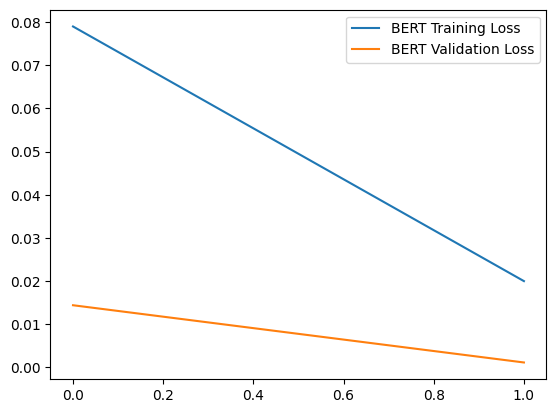

In [ ]:
plt.plot(history.history['loss'], label='BERT Training Loss')
plt.plot(history.history['val_loss'], label='BERT Validation Loss')
plt.legend()
plt.show()

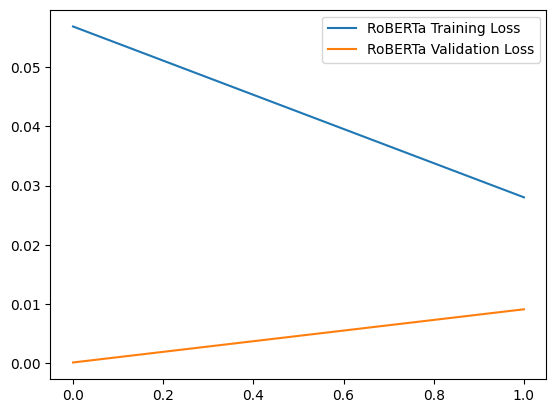

In [ ]:
plt.plot(history2.history['loss'], label='RoBERTa Training Loss')
plt.plot(history2.history['val_loss'], label='RoBERTa Validation Loss')
plt.legend()
plt.show()

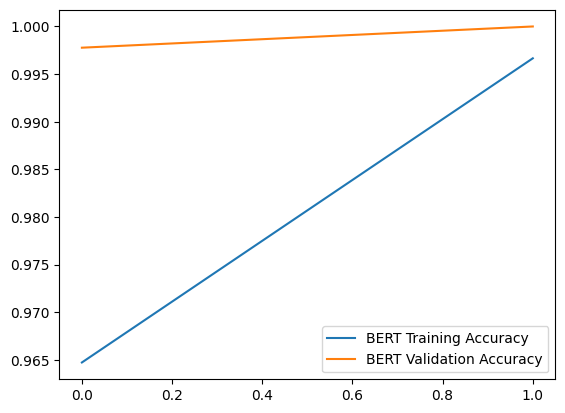

In [ ]:
plt.plot(history.history['accuracy'], label='BERT Training Accuracy')
plt.plot(history.history['val_accuracy'], label='BERT Validation Accuracy')
plt.legend()
plt.show()

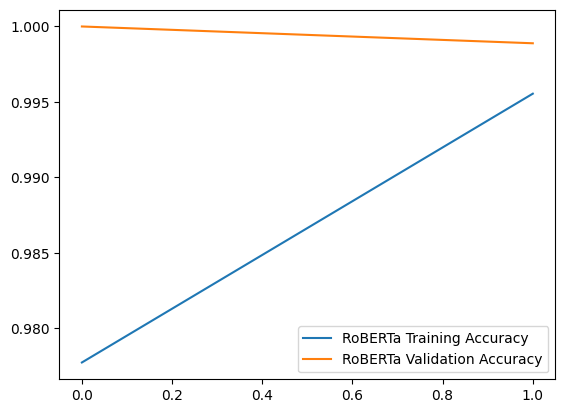

In [ ]:
plt.plot(history2.history['accuracy'], label='RoBERTa Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='RoBERTa Validation Accuracy')
plt.legend()
plt.show()

#LR

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")


In [ ]:
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

y_train = train_labels
y_val = val_labels
y_test = test_labels

In [ ]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_val_preds = logistic_model.predict(X_val)
print(classification_report(y_val, y_val_preds))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       470
           1       0.95      0.97      0.96       428

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898



In [ ]:
y_test_preds = logistic_model.predict(X_test)
print(classification_report(y_test, y_test_preds))


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       470
           1       0.96      0.96      0.96       428

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898



New dataset

In [ ]:
df_new = pd.read_csv("train.csv")
df_new = df_new.dropna(subset=['title', 'text', 'label'])

In [ ]:
df_new

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
train_val_texts2, test_texts2, train_val_labels2, test_labels2 = train_test_split(
    df_new['text'], df_new['label'], test_size=0.2, stratify = df_new['label'], random_state=42)
# 60% train, 20% val
train_texts2, val_texts2, train_labels2, val_labels2 = train_test_split(
    train_val_texts2, train_val_labels2, test_size=0.25, stratify = train_val_labels2, random_state=42 )

#LR2

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")


In [ ]:
X_train = vectorizer.fit_transform(train_texts2)
X_val = vectorizer.transform(val_texts2)
X_test = vectorizer.transform(test_texts2)

y_train = train_labels2
y_val = val_labels2
y_test = test_labels2

In [ ]:
logistic_model2 = LogisticRegression(max_iter=1000, random_state=42)
logistic_model2.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_val_preds2 = logistic_model2.predict(X_val)
print(classification_report(y_val, y_val_preds2))


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2078
           1       0.94      0.96      0.95      1963

    accuracy                           0.95      4041
   macro avg       0.95      0.95      0.95      4041
weighted avg       0.95      0.95      0.95      4041



In [ ]:
y_test_preds2 = logistic_model2.predict(X_test)
print(classification_report(y_test, y_test_preds2))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2078
           1       0.93      0.95      0.94      1963

    accuracy                           0.94      4041
   macro avg       0.94      0.94      0.94      4041
weighted avg       0.94      0.94      0.94      4041



New Models

In [ ]:
train_val_texts2, test_texts2, train_val_labels2, test_labels2 = train_test_split(
    df_new['text'], df_new['label'], test_size=0.2, stratify = df_new['label'], random_state=42)
# 60% train, 20% val
train_texts2, val_texts2, train_labels2, val_labels2 = train_test_split(
    train_val_texts2, train_val_labels2, test_size=0.25, stratify = train_val_labels2, random_state=42 )

In [ ]:
b_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
train_encodings2 = encode_texts(train_texts2, b_tokenizer)
val_encodings2 = encode_texts(val_texts2, b_tokenizer)
test_encodings2 = encode_texts(test_texts2, b_tokenizer)

In [ ]:
# Convert to tf dataset
train_dataset2 = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings2["input_ids"],
        "attention_mask": train_encodings2["attention_mask"]
    },
    train_labels2
)).batch(BATCH_SIZE)

val_dataset2 = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": val_encodings2["input_ids"],
        "attention_mask": val_encodings2["attention_mask"]
    },
    val_labels2
)).batch(BATCH_SIZE)

test_dataset2 = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings2["input_ids"],
        "attention_mask": test_encodings2["attention_mask"]
    },
    test_labels2
)).batch(BATCH_SIZE)

In [ ]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_classification_model2 = create_transformer_classification_model(bert_model, num_train_layers = 2  )
history2b = bert_classification_model2.fit(train_dataset2, validation_data=val_dataset2, epochs=EPOCHS)

Epoch 1/2
758/758 [==============================] - 410s 490ms/step - loss: 0.1133 - accuracy: 0.9545 - val_loss: 0.0413 - val_accuracy: 0.9869
Epoch 2/2
758/758 [==============================] - 362s 478ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.0727 - val_accuracy: 0.9834


In [ ]:
bert_preds2 = (bert_classification_model2.predict(test_dataset2) > 0.5).astype("int32").flatten()


253/253 [==============================] - 41s 147ms/step


In [ ]:
print("BERT Model Results:")
print(classification_report(test_labels2, bert_preds2))

BERT Model Results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2078
           1       1.00      0.97      0.98      1963

    accuracy                           0.98      4041
   macro avg       0.98      0.98      0.98      4041
weighted avg       0.98      0.98      0.98      4041



# Roberta

In [ ]:
r_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
train_encodings2r = encode_texts(train_texts2, r_tokenizer)
val_encodings2r = encode_texts(val_texts2, r_tokenizer)
test_encodings2r = encode_texts(test_texts2, r_tokenizer)

In [ ]:
# Convert to tf dataset
train_dataset2r = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings2r["input_ids"],
        "attention_mask": train_encodings2r["attention_mask"]
    },
    train_labels2
)).batch(BATCH_SIZE)

val_dataset2r = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": val_encodings2r["input_ids"],
        "attention_mask": val_encodings2r["attention_mask"]
    },
    val_labels2
)).batch(BATCH_SIZE)

test_dataset2r = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings2r["input_ids"],
        "attention_mask": test_encodings2r["attention_mask"]
    },
    test_labels2
)).batch(BATCH_SIZE)

In [ ]:
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
roberta_classification_model2r = create_transformer_classification_model(roberta_model, num_train_layers = 2  )
history2r = roberta_classification_model2r.fit(train_dataset2r, validation_data=val_dataset2r, epochs=EPOCHS)

Epoch 1/2
758/758 [==============================] - 406s 485ms/step - loss: 0.0559 - accuracy: 0.9804 - val_loss: 0.0291 - val_accuracy: 0.9884
Epoch 2/2
758/758 [==============================] - 364s 481ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.0277 - val_accuracy: 0.9923


In [ ]:
roberta_preds2r = (roberta_classification_model2r.predict(test_dataset2r) > 0.5).astype("int32").flatten()


253/253 [==============================] - 39s 146ms/step


In [ ]:
print("RoBERTa Model Results:")
print(classification_report(test_labels2, roberta_preds2r))

RoBERTa Model Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2078
           1       1.00      0.99      0.99      1963

    accuracy                           0.99      4041
   macro avg       0.99      0.99      0.99      4041
weighted avg       0.99      0.99      0.99      4041



In [ ]:
test_labels.head()

,label
8767,1
6804,0
43845,1
31712,0
17006,0


In [ ]:
test_labels_inv= 1 - test_labels #inverting bc old dataset had labels in reverse

In [ ]:
test_labels_inv.head()

,label
8767,0
6804,1
43845,0
31712,1
17006,1


In [ ]:
test_encodings_b = encode_texts(test_texts, b_tokenizer)
test_dataset_invb = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings_b["input_ids"],
        "attention_mask": test_encodings_b["attention_mask"]
    },
    test_labels_inv
)).batch(BATCH_SIZE)

In [ ]:
test_encodings_invr = encode_texts(test_texts, r_tokenizer)
test_dataset_invr = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings_invr["input_ids"],
        "attention_mask": test_encodings_invr["attention_mask"]
    },
    test_labels_inv
)).batch(BATCH_SIZE)

In [ ]:
bert_preds_invb = (bert_classification_model2.predict(test_dataset_invb) > 0.5).astype("int32").flatten()
print("BERT Model Results:")
print(classification_report(test_labels_inv, bert_preds_invb))

57/57 [==============================] - 8s 144ms/step
BERT Model Results:
              precision    recall  f1-score   support

           0       0.65      0.35      0.45       428
           1       0.58      0.83      0.69       470

    accuracy                           0.60       898
   macro avg       0.62      0.59      0.57       898
weighted avg       0.62      0.60      0.57       898



In [ ]:
roberta_preds_invb = (roberta_classification_model2r.predict(test_dataset_invr) > 0.5).astype("int32").flatten()
print("RoBERTa Model Results:")
print(classification_report(test_labels_inv, roberta_preds_invb))

57/57 [==============================] - 8s 138ms/step
RoBERTa Model Results:
              precision    recall  f1-score   support

           0       0.47      0.89      0.61       428
           1       0.44      0.08      0.14       470

    accuracy                           0.47       898
   macro avg       0.46      0.48      0.38       898
weighted avg       0.45      0.47      0.36       898

